# 베를린에 있는 Airbnb Host를 위한 가격(숙박비) 예측

## 목차
1. data 불러오기


2. 데이터 전처리
   - 컬럼 선택
   - 가격 컬럼 정제하기
   - 결측치 다루기
   - feature engineering: 베를린 중심가에서의 거리 연관성
   - feature engineering: 크기에 따른 가격 연관성
   - feature engineering: 편의시설 유무에 따른 가격 연관성


3. EDA


4. Modeling
   - 종속변수와 독립변수 준비
   - Splitting and Scaling the Data
   - XGBoost Regressor를 이용한 학습
   - Cross Validation

### 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_initial = pd.read_csv('listings_summary.csv')
print('{} rows, {} columns.'.format(*df_initial.shape))

22552 rows, 96 columns.


In [7]:
# 중복 데이터 확인
df_initial.duplicated().sum()

0

In [8]:
df_initial.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


In [9]:
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

### 2. 데이터 전처리
- 컬럼 선택

In [40]:
selected_columns = ['id', 'space', 'description', 'host_has_profile_pic',
                    'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[selected_columns].set_index('id')
print('{} rows and {} columns'.format(*df_raw.shape))

22552 rows and 23 columns


In [43]:
df_raw.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [44]:
df_raw.room_type.value_counts(normalize=True)

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

In [47]:
df_raw.property_type.unique()

array(['Guesthouse', 'Apartment', 'Condominium', 'Loft', 'House',
       'Serviced apartment', 'Townhouse', 'Boutique hotel',
       'Bed and breakfast', 'Bungalow', 'Boat', 'Guest suite', 'Other',
       'Island', 'Hostel', 'Train', 'Camper/RV', 'Houseboat', 'Cabin',
       'Cottage', 'Tiny house', 'Chalet', 'Castle', 'Villa', 'Aparthotel',
       'Hotel', 'Tipi', 'Resort', 'In-law', 'Cave', 'Barn',
       'Pension (South Korea)', 'Casa particular (Cuba)'], dtype=object)

In [48]:
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Camper/RV                 0.000488
Houseboat                 0.000488
Villa                     0.000443
Pension (South Korea)     0.000310
Aparthotel                0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Casa particular (Cuba)    0.000089
Castle                    0.000089
Train                     0.000089
Tipi                      0.000044
Barn                

### 가격 관련 컬럼 정제

In [50]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


In [55]:
# 비어있는 값 확인하기
df_raw.price.isna().sum()

0

In [56]:
df_raw.cleaning_fee.isna().sum()

7146

In [57]:
df_raw.extra_people.isna().sum()

0

In [58]:
df_raw.security_deposit.isna().sum()

9361

Nan 값이 있는 컬럼을 '$0.00' 달러로 채워주자

In [68]:
df_raw.cleaning_fee.fillna(value='$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

In [69]:
df_raw.security_deposit.fillna(value='$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [70]:
df_raw.extra_people.isna().sum()

0

In [71]:
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)


In [72]:
df_raw['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

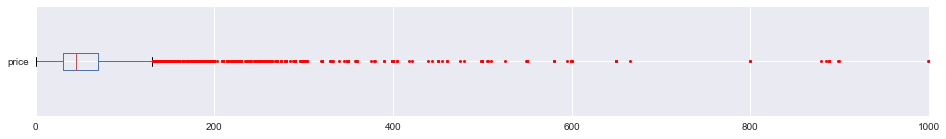

In [74]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16, 2))
plt.show()

In [76]:
df_raw.drop(df_raw[(df_raw.price > 400) | (df_raw.price == 0)].index, axis=0, inplace=True)

In [77]:
df_raw['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [78]:
print('{} rows, {} columns'.format(*df_raw.shape))

22441 rows, 23 columns


### 결측치 다루기

In [79]:
df_raw.isna().sum()

space                            8503
description                       202
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [81]:
# Nan 값이 너무 많은 컬럼은 삭제
df_raw.drop(columns=['space', 'square_feet'], inplace=True)

In [84]:
# 약간의 Nan이 있는 컬럼은 해당 row만 삭제
df_raw.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)

In [87]:
# 프로필 사진 유무를 나타내는 컬럼 확인 -> nan값이 존재
df_raw.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [88]:
# nan 값은 사진이 없다는 의미이므로
df_raw.host_has_profile_pic.fillna('f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [89]:
df_raw.isna().sum()

description                     202
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

### Feature Engineering - 베를린 중심가로부터의 거리

In [90]:
from geopy.distance import great_circle

In [93]:
def distance_to_mid(lat, longitude):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, longitude)
    return great_circle(berlin_centre, accommodation).km

In [94]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [118]:
df_raw[['distance']].head()

,distance
id,
2015,3.533182
2695,5.085573
3176,3.695677
3309,3.755285
7071,4.550423


### Feature Engineering - 숙소 크기 

In [113]:
# description 컬럼은 내용이 많아보인다.
list(df_raw.description[:10])

['Great location!  30 of 75 sq meters. This wood floored/high ceiling typical Berlin "Altbau" section of an apartment consists of 1 simple large room, a small kitchen and a bathroom + shower. The apartment is in Mitte, close to Prenzlauer Berg/Mauerpark. Perfect for short visits, singles or couples. Your section is closed from the rest of the bigger flat wich is not noticeable. You will not be sharing your space. A+++ location! This „Einliegerwohnung“ is an extention of a larger apartment with a separate entrance, bathroom and kitchen. The door to the rest of the apartment is soundproof, hidden, locked and barely noticable (behind mirror in pictures). Your 30 sq meters are facing a quiet courtyard. This wood floored/high ceiling typical Berlin "Altbau" apartment consists of 1 large room with a large double bed, optionally with an extra matress for a 3rd guest), a small kitchen suitable for preparing simple meals, a bathroom + shower + bathtub and of course your own entrance (all linens

In [116]:
# 결측치 확인
print(df_raw.description.isna().sum())

202


In [136]:
# 숫자 추출하기 
# 두 자리 혹은 세 자리 숫자 추출, s나 m이 들어가는 단어 추출 
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])',
                                                   expand=True)
# 숫자가 없는 데이터는 공백으로 대체
df_raw['size'] = df_raw['size'].str.replace('\D', '')
# 실수(float)로 변환 
df_raw['size'] = df_raw['size'].astype(float)

print(df_raw['size'].isna().sum())
print(round(df_raw['size'].isna().sum() / len(df_raw), 3), '%')


11721
0.523 %


In [138]:
df_raw[['description', 'size']].head(10)

,description,size
id,,
2015,Great location! 30 of 75 sq meters. This wood...,75.0
2695,In the summertime we are spending most of our ...,25.0
3176,This beautiful first floor apartment is situa...,68.0
3309,First of all: I prefer short-notice bookings. ...,26.0
7071,Cozy and large room in the beautiful district ...,20.0
9991,4 bedroom with very large windows and outstand...,780.0
14325,The apartment is located on the upper second f...,NaN
16401,Hello future guests! We want to rent our cute ...,55.0
16644,Light and sunny 2-Room-turn of the century-fla...,80.0


In [ ]:
df_raw

In [140]:
list(df_raw.description[:10])

['Great location!  30 of 75 sq meters. This wood floored/high ceiling typical Berlin "Altbau" section of an apartment consists of 1 simple large room, a small kitchen and a bathroom + shower. The apartment is in Mitte, close to Prenzlauer Berg/Mauerpark. Perfect for short visits, singles or couples. Your section is closed from the rest of the bigger flat wich is not noticeable. You will not be sharing your space. A+++ location! This „Einliegerwohnung“ is an extention of a larger apartment with a separate entrance, bathroom and kitchen. The door to the rest of the apartment is soundproof, hidden, locked and barely noticable (behind mirror in pictures). Your 30 sq meters are facing a quiet courtyard. This wood floored/high ceiling typical Berlin "Altbau" apartment consists of 1 large room with a large double bed, optionally with an extra matress for a 3rd guest), a small kitchen suitable for preparing simple meals, a bathroom + shower + bathtub and of course your own entrance (all linens

In [141]:
# 전처리에 오류가 많다. 컬럼 삭제
df_raw.drop(['description'], axis=1, inplace=True)

### 결측치를 회귀로 예측해보기

In [142]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22391 entries, 2015 to 29867352
Data columns (total 22 columns):
host_has_profile_pic            22391 non-null object
neighbourhood_group_cleansed    22391 non-null object
latitude                        22391 non-null float64
longitude                       22391 non-null float64
property_type                   22391 non-null object
room_type                       22391 non-null object
accommodates                    22391 non-null int64
bathrooms                       22391 non-null float64
bedrooms                        22391 non-null float64
bed_type                        22391 non-null object
amenities                       22391 non-null object
price                           22391 non-null float64
cleaning_fee                    22391 non-null float64
security_deposit                22391 non-null float64
extra_people                    22391 non-null float64
guests_included                 22391 non-null int64
minimum_nights 

여전히 size 컬럼에 결측치가 많다

세부적으로 컬럼을 선택해서 선형회귀모델로 결측치를 예측해보자.


In [218]:
# 가격에 연관된 독립변수 선택 
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms', 'price',
                 'cleaning_fee', 'security_deposit', 'extra_people',
                 'guests_included', 'distance', 'size']]

In [233]:
sub_df.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
id,,,,,,,,,,
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0


In [234]:
train_data = sub_df[sub_df['size'].notnull()]
test_data = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [322]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [326]:
y_test = linreg.predict(X_test)

In [327]:
y_test

array([56.69728052, 97.75690567, 75.83159184, ..., 60.48258104,
       65.17808059, 47.8061606 ])

In [328]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']

In [329]:
print(y_test.shape)
y_test.head()

(11721, 1)


,size
0,56.697281
1,97.756906
2,75.831592
3,88.778838
4,60.680846


In [330]:
print(X_test.shape)
X_test.head()

(11721, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509


In [331]:
new_index = pd.DataFrame(X_test.index)
new_index.columns = ['new_index']

y_test = pd.concat([y_test, new_index], axis=1)
y_test.set_index(['new_index'], inplace=True)
y_test.head()

,size
new_index,
14325,56.697281
20858,97.756906
21869,75.831592
22415,88.778838
28156,60.680846


In [332]:
print(X_test.shape)
X_test.head()

(11721, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509


완전한 test data로 만들기

In [333]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [334]:
print(new_test_data.shape)
new_test_data.head()

(11721, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.831592
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.778838
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,60.680846


In [250]:
new_test_data['size'].isnull().sum()

0

In [252]:
sub_df_new = pd.concat([new_test_data, train_data], axis=0)
print(sub_df_new.shape)
sub_df_new.head()

(22391, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.831592
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.778838
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,60.680846


In [255]:
sub_df_new['size'].isna().sum()

0

In [257]:
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price',
             'cleaning_fee', 'security_deposit', 'extra_people',
             'guests_included', 'distance', 'size'], axis=1, inplace=True)

In [258]:
# 데이터 프레임 원상복구 시키기
df = pd.concat([sub_df_new, df_raw], axis=1)
print(df.shape)
df.head()

(22391, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible
3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,3.695677,68.0,...,52.534996,13.417579,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",62,t,f,strict_14_with_grace_period
3309,2,1.0,1.0,26.0,30.0,250.0,18.0,1,3.755285,26.0,...,52.498855,13.349065,Apartment,Private room,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",5,f,f,strict_14_with_grace_period
7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,4.550423,20.0,...,52.543157,13.415091,Apartment,Private room,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",2,f,f,moderate


##### size 컬럼 조사해보기

In [259]:
df['size'].isna().sum()

0

In [260]:
df['size'].describe()

count    22391.000000
mean        60.297112
std         80.937597
min          0.000000
25%         25.000000
50%         49.573940
75%         65.014837
max        980.000000
Name: size, dtype: float64

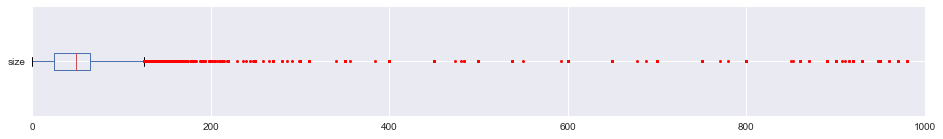

In [261]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2))

300 부터는 아웃라이어로 판단하여 제외.(0도 제외)

In [263]:
df.drop(df[(df['size'] > 300.) | (df['size'] == 0.)].index, axis=0, inplace=True)

In [264]:
df.shape

(21958, 22)

### Feature Engineering - 편의시설 여부

In [265]:
from collections import Counter

In [291]:
results = Counter()
df['amenities'].str.strip('{}').str.replace('"', '')\
               .str.lstrip('\"').str.rstrip('\"').str.split(',')\
               .apply(results.update)
results.most_common(30)

[('Wifi', 20952),
 ('Kitchen', 20809),
 ('Heating', 20657),
 ('Essentials', 19811),
 ('Washer', 18071),
 ('Hair dryer', 14474),
 ('Laptop friendly workspace', 14095),
 ('Hangers', 13514),
 ('Iron', 10876),
 ('Shampoo', 10339),
 ('TV', 9778),
 ('Hot water', 9421),
 ('Family/kid friendly', 7925),
 ('Internet', 7699),
 ('Host greets you', 6469),
 ('Smoke detector', 6245),
 ('Buzzer/wireless intercom', 5963),
 ('Lock on bedroom door', 5138),
 ('Free street parking', 5037),
 ('Refrigerator', 5033),
 ('Dishes and silverware', 4909),
 ('Elevator', 4703),
 ('Cooking basics', 4673),
 ('Bed linens', 4656),
 ('Stove', 4655),
 ('Smoking allowed', 4509),
 ('Oven', 4161),
 ('translation missing: en.hosting_amenity_50', 4095),
 ('First aid kit', 3866),
 ('Cable TV', 3577)]

In [305]:
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

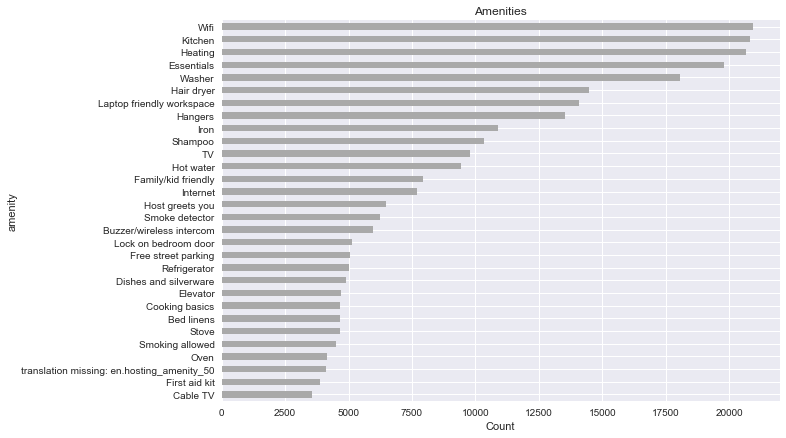

In [335]:
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh',
                                                      x='amenity', y='count', figsize=(10, 7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count')
plt.show()

편의시설 중 어느 정도 특별하고 모든 주인들이 제공하지 않는 것들의 컬럼을 따로 뽑아보자.

In [340]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace') 
df['TV'] = df['amenities'].str.contains('TV')
df['family_kid_friendly'] = df['amenities'].str.contains('Family/kid_friendly')
df['host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [341]:
df.drop(['amenities'], axis=1, inplace=True)

## EDA

##### 위도 경도에 따른 차이

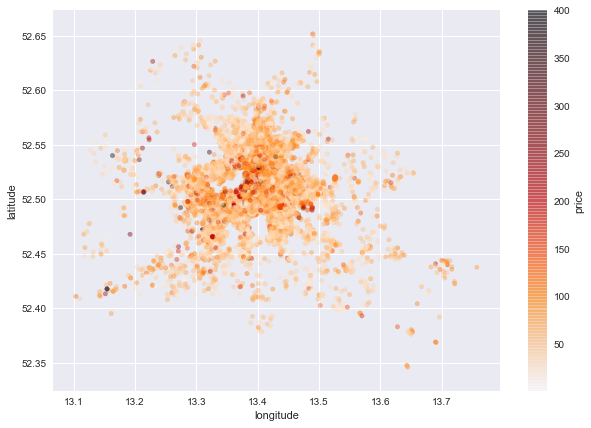

In [344]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
        figsize=(10, 7), c='price', cmap='gist_heat_r', colorbar=True,
        sharex=False)
plt.show()

##### 구역에 따른 차이


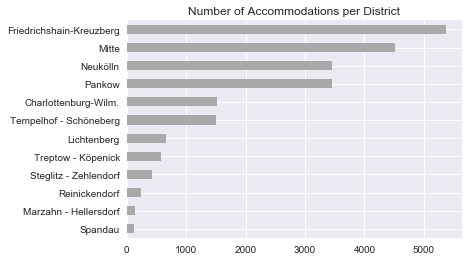

In [364]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District')
plt.show()

In [365]:
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))

In [367]:
df_grouped.reset_index(inplace=True)

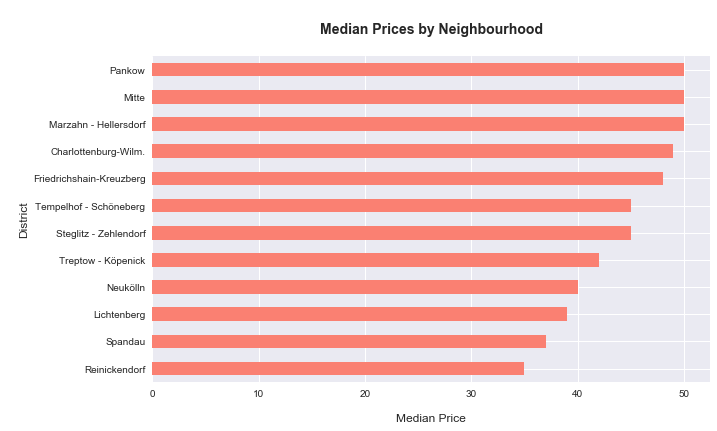

In [379]:
df_grouped.sort_values(by='price', ascending=True).plot(kind='barh',
                                                        x='neighbourhood_group_cleansed', y='price', figsize=(10, 6), legend=False, color='salmon')
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('\nDistrict', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold')
plt.show()

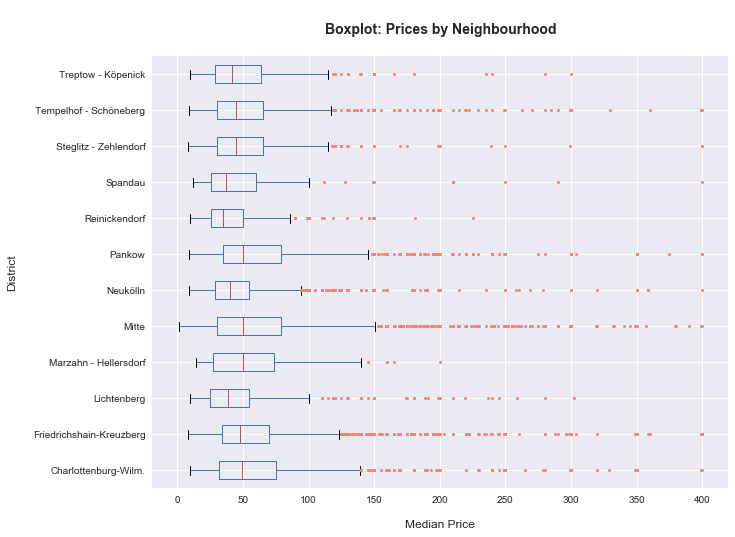

In [397]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')
df.boxplot(column='price', by='neighbourhood_group_cleansed', flierprops=red_square, vert=False, figsize=(10, 8))
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

plt.suptitle('')
plt.show()

베를린 중심으로부터의 거리와 가격의 관계

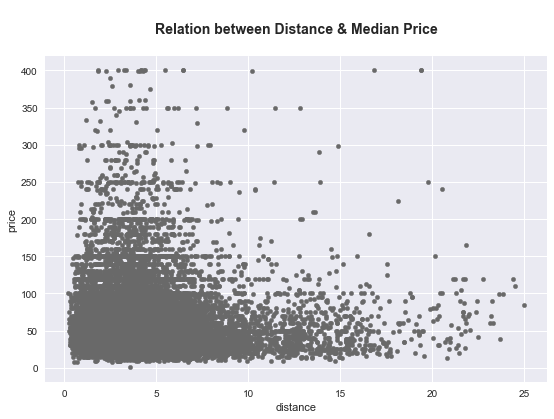

In [399]:
df.plot.scatter(x='distance', y='price', figsize=(9, 6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold')
plt.show()

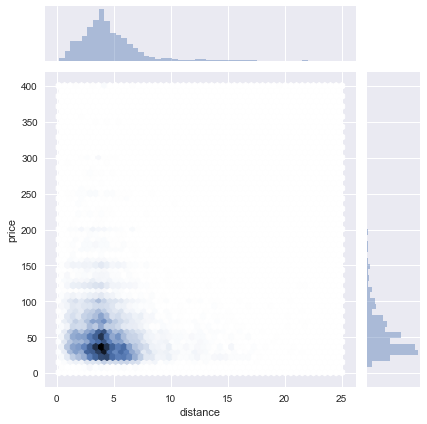

In [402]:
sns.jointplot(x=df['distance'], y=df['price'], kind='hex')

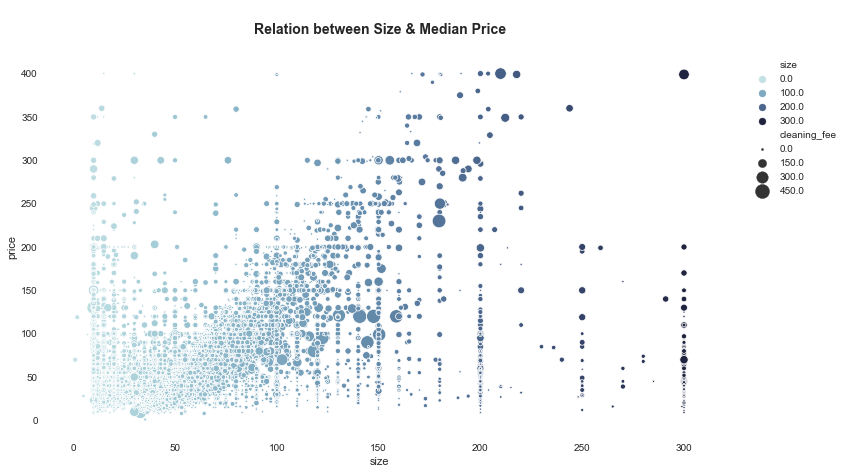

In [414]:
sns.set_style('white')
cmap = sns.cubehelix_palette(rot=-0.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.scatterplot(x='size', y='price', size='cleaning_fee', sizes=(5, 200),
                     hue='size', palette=cmap, data=df)
plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


침대 갯수에 따른 가격 차이

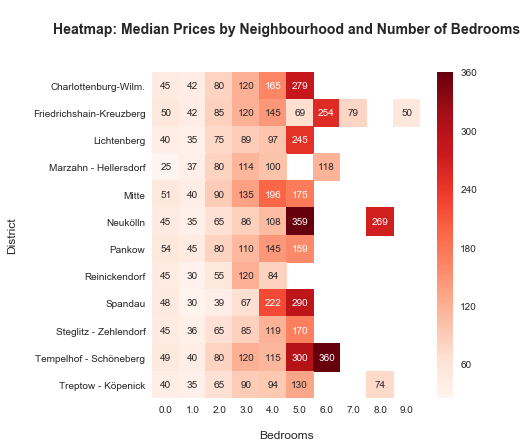

In [421]:
plt.figure(figsize=(6, 6))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(),
            cmap='Reds', annot=True, fmt='.0f')
plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold')
plt.show()

취소 정책(노쇼, 취소에 따른 페널티)에 따른 가격차이

In [439]:
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy']).price.median())
df_grouped.reset_index(inplace=True)

Text(0.5, 1.0, '\nMedian Prices by Cancellation Policy\n')

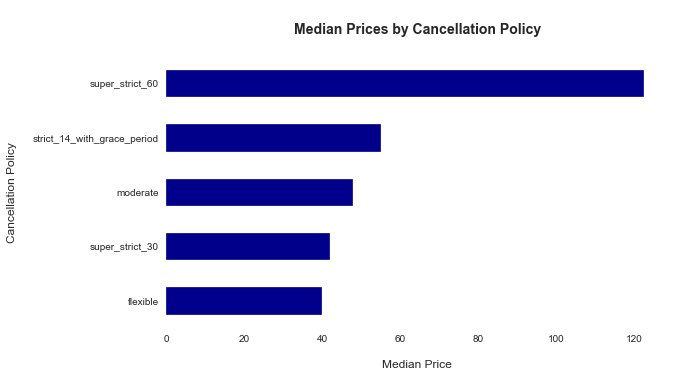

In [452]:
df_grouped.sort_values(by='price', ascending=True).plot(kind='barh', x='cancellation_policy', y='price',
                                                        figsize=(9, 5), legend=False, color='darkblue')
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold')

## Modeling the Data

### 종속 변수와 독립 변수 준비

In [453]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance',
       'size', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'Laptop_friendly_workspace', 'TV',
       'family_kid_friendly', 'host_greets_you', 'smoking_allowed'],
      dtype='object')

In [455]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21958 entries, 2015 to 29867352
Data columns (total 26 columns):
accommodates                    21958 non-null int64
bathrooms                       21958 non-null float64
bedrooms                        21958 non-null float64
price                           21958 non-null float64
cleaning_fee                    21958 non-null float64
security_deposit                21958 non-null float64
extra_people                    21958 non-null float64
guests_included                 21958 non-null int64
distance                        21958 non-null float64
size                            21958 non-null float64
host_has_profile_pic            21958 non-null object
neighbourhood_group_cleansed    21958 non-null object
latitude                        21958 non-null float64
longitude                       21958 non-null float64
property_type                   21958 non-null object
room_type                       21958 non-null object
bed_type     

불필요한 컬럼들을 제거하기.

중심으로부터의 거리를 구했으므로 지리적인 컬럼은 삭제, 숙소 형태도 별 도움이 안되기 때문에 삭제


In [462]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed',
         'property_type'], axis=1, inplace=True)

In [466]:
# 명목형 데이터
df.describe(include=np.object)

,host_has_profile_pic,room_type,bed_type,instant_bookable,is_business_travel_ready,cancellation_policy
count,21958,21958,21958,21958,21958,21958
unique,2,3,5,2,1,5
top,t,Private room,Real Bed,f,f,flexible
freq,21878,11286,21192,15153,21958,8886


In [469]:
# 문자열 컬럼을 카테고리값으로 변환
string_columns = ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable',
                  'is_business_travel_ready', 'cancellation_policy']

for col in string_columns:
    df[col] = df[col].astype('category')

In [475]:
# 종속변수(target value) 설정
target = df[['price']]

# 독립변수(feature value) 설정
features = df.drop(['price'], inplace=False, axis=1)

수치형 데이터와 카테고리형 데이터를 분류하고 합치기

In [478]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [480]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [483]:
print(features_recoded.shape)
features_recoded.head()

(21958, 33)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,...,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,...,0,1,1,0,1,1,0,0,0,0
3176,4,1.0,1.0,50.0,200.0,20.0,2,3.695677,68.0,62,...,0,1,0,1,1,0,0,1,0,0
3309,2,1.0,1.0,30.0,250.0,18.0,1,3.755285,26.0,5,...,1,0,1,0,1,0,0,1,0,0
7071,2,1.0,1.0,0.0,0.0,24.0,1,4.550423,20.0,2,...,0,1,1,0,1,0,1,0,0,0


In [520]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2, random_state=42)

In [521]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17566, 33), (4392, 33), (17566, 1), (4392, 1))

In [522]:
# 독립 변수들 간의 단위가 다르므로 scaling을 한다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [523]:
# baseling 모델
model = xgb.XGBRegressor()

In [524]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [525]:
# Parameters 튜닝
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'n_estimators': [int(x) for x in range(100, 201, 10)],
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 6, 7],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.0, 0.1, 0.2]}

In [526]:
random_search = RandomizedSearchCV(model, param_grid, cv=3, n_jobs=-1)

In [527]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [5, 6, 7], 'colsample_bytree': [0.6, 0.7], 'gamma': [0.0, 0.1, 0.2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [528]:
random_search.best_params_

{'n_estimators': 180,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.6}

In [529]:
model = xgb.XGBRegressor(colsample_bytree=0.6, n_estimators=180,
                         max_depth=6, learning_rate=0.1, gamma=0.0, random_state=42)

In [530]:
# train
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=180, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [531]:
# predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [532]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
RMSE

23.59637585547978

In [533]:
r2_score(y_test, y_pred_test)

0.6971455046884538

## XGBoost에서 제공하는 방법

In [536]:
xgb_train = xgb.DMatrix(data=X_train, label=y_train)

In [538]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}
xgb.cv(dtrain=xgb_train, params=params, nfold=3, num_boost_round=200,
       early_stopping_rounds=10, metrics='rmse', as_pandas=True)



[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:35:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[17:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned node

[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, m

[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes,

[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:35:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, 

[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, ma

[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, ma

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,67.759506,0.149932,67.804377,0.283166
1,64.972468,0.166997,65.063817,0.229886
2,62.336437,0.210415,62.456814,0.191311
3,59.831529,0.206052,59.986211,0.139062
4,57.494537,0.230929,57.701105,0.146154
5,55.332639,0.265276,55.592257,0.237155
6,53.261237,0.185750,53.557898,0.213895
7,51.295849,0.237767,51.646712,0.250310
8,49.429151,0.282854,49.832120,0.293308
9,47.660003,0.242752,48.107746,0.289917
